In [14]:
import pandas as pd
import numpy as np
from bisect import bisect_left
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
# Load the parquet file
df = pd.read_parquet('../data/storm_and_outage_merged_2014_2023.parquet')

# Display the first few rows to get a sense of the data
print(df.head())

# Basic info about the dataframe
print("\nDataframe info:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")

c:\Users\Dell\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


   customers_out power_outage_datetime storm_start_datetime_est  \
0            4.0   2014-11-23 12:15:00      2014-11-23 12:05:00   
1           65.0   2014-12-23 15:45:00      2014-12-23 15:44:00   
2           53.0   2014-12-23 17:00:00      2014-12-23 17:00:00   
3           47.0   2014-12-23 17:15:00      2014-12-23 17:00:00   
4           33.0   2014-12-23 19:30:00      2014-12-23 19:30:00   

  storm_end_datetime_est  duration_hours    STATE  STATE_FIPS  \
0    2014-11-23 12:25:00        0.333333  ALABAMA         1.0   
1    2014-12-23 15:45:00        0.016667  ALABAMA         1.0   
2    2014-12-23 19:30:00        2.500000  ALABAMA         1.0   
3    2014-12-23 19:30:00        2.500000  ALABAMA         1.0   
4    2014-12-23 19:31:00        0.016667  ALABAMA         1.0   

          EVENT_TYPE CZ_TYPE  CZ_FIPS  ...  WFO INJURIES_DIRECT  \
0  Thunderstorm Wind       C     45.0  ...  TAE             0.0   
1  Thunderstorm Wind       C    119.0  ...  BMX             0.0   
2    

c:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Summary Statistics for MAGNITUDE_IMPUTED:
count    407011.000000
mean         25.757523
std          26.076217
min           0.250000
25%           1.162383
50%           2.249100
75%          51.325667
max         173.000000
Name: MAGNITUDE_IMPUTED, dtype: float64


<Figure size 1200x600 with 0 Axes>

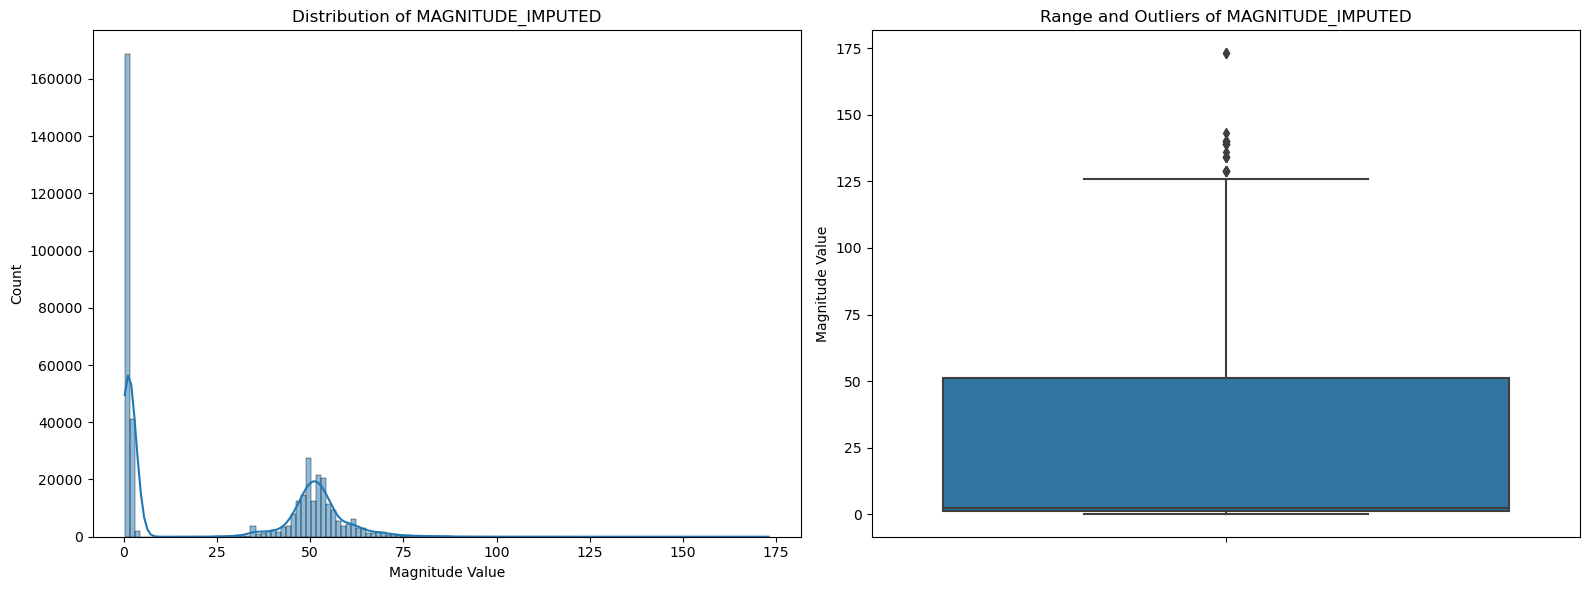

In [ ]:
"""
Task:
Visualize the distribution and statistical properties of the `MAGNITUDE_IMPUTED` column in the dataset.

Steps:
1. Create a figure with two subplots:
   - Left subplot: Histogram with KDE to show the distribution of `MAGNITUDE_IMPUTED`.
   - Right subplot: Box plot to display the range and outliers of `MAGNITUDE_IMPUTED`.
2. Set appropriate titles, labels, and figure size for clarity.
3. Compute and print summary statistics for `MAGNITUDE_IMPUTED`.
4. Apply tight layout and display the plots.

Notes:
- Assumes the input dataset (`df`) contains the `MAGNITUDE_IMPUTED` column.
- Uses `seaborn` for enhanced visualization and `matplotlib` for plotting.
"""
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Histogram with KDE to show the distribution
sns.histplot(df['MAGNITUDE_IMPUTED'], kde=True, ax=ax1)
ax1.set_title('Distribution of MAGNITUDE_IMPUTED')
ax1.set_xlabel('Magnitude Value')
ax1.set_ylabel('Count')

# Plot 2: Box plot to show the range and outliers
sns.boxplot(y=df['MAGNITUDE_IMPUTED'], ax=ax2)
ax2.set_title('Range and Outliers of MAGNITUDE_IMPUTED')
ax2.set_ylabel('Magnitude Value')

# Display summary statistics
summary_stats = df['MAGNITUDE_IMPUTED'].describe()
print("Summary Statistics for MAGNITUDE_IMPUTED:")
print(summary_stats)

plt.tight_layout()
plt.show()

In [ ]:
# We check how many values fall into the ranges 0-25 and 25-100 to understand the distribution and form a classification between no storm and isstorm
count_0_25 = df[(df['MAGNITUDE_IMPUTED'] >= 0) & (df['MAGNITUDE_IMPUTED'] < 25)].shape[0]
count_25_100 = df[(df['MAGNITUDE_IMPUTED'] >= 25) & (df['MAGNITUDE_IMPUTED'] <= 100)].shape[0]

# Display the counts
print(f"Count of values between 0-25: {count_0_25}")
print(f"Count of values between 25-100: {count_25_100}")

# Calculate percentages of total
total_count = df.shape[0]
percent_0_25 = (count_0_25 / total_count) * 100
percent_25_100 = (count_25_100 / total_count) * 100

print(f"Percentage of values between 0-25: {percent_0_25:.2f}%")
print(f"Percentage of values between 25-100: {percent_25_100:.2f}%")

Count of values between 0-25: 211744
Count of values between 25-100: 195037
Percentage of values between 0-25: 52.02%
Percentage of values between 25-100: 47.92%


In [ ]:
# Task: Classify storms based on the `MAGNITUDE_IMPUTED` and check the distribution of storm categories.
df['is_storm'] = 0
df.loc[df['MAGNITUDE_IMPUTED'] >= 25, 'is_storm'] = 1

# Display counts and percentages of each category
storm_counts = df['is_storm'].value_counts()
storm_percentages = df['is_storm'].value_counts(normalize=True) * 100

# Create a summary dataframe
summary_df = pd.DataFrame({
    'Count': storm_counts,
    'Percentage': storm_percentages.round(2)
})

print("Storm classification summary:")
print(summary_df)


Storm classification summary:
           Count  Percentage
is_storm                    
0         211744       52.02
1         195267       47.98


In [7]:
df

,customers_out,power_outage_datetime,storm_start_datetime_est,storm_end_datetime_est,duration_hours,STATE,STATE_FIPS,EVENT_TYPE,CZ_TYPE,CZ_FIPS,...,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE_IMPUTED,MAGNITUDE_TYPE_IMPUTED,is_storm
0,4.0,2014-11-23 12:15:00,2014-11-23 12:05:00,2014-11-23 12:25:00,0.333333,ALABAMA,1.0,Thunderstorm Wind,C,45.0,...,0.0,0.0,0.0,0.0,3000.0,0.0,Emergency Manager,55.00000,EG,1
1,65.0,2014-12-23 15:45:00,2014-12-23 15:44:00,2014-12-23 15:45:00,0.016667,ALABAMA,1.0,Thunderstorm Wind,C,119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Amateur Radio,50.00000,EG,1
2,53.0,2014-12-23 17:00:00,2014-12-23 17:00:00,2014-12-23 19:30:00,2.500000,ALABAMA,1.0,Flash Flood,C,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Emergency Manager,0.92894,MS,0
3,47.0,2014-12-23 17:15:00,2014-12-23 17:00:00,2014-12-23 19:30:00,2.500000,ALABAMA,1.0,Flash Flood,C,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Emergency Manager,0.92894,MS,0
4,33.0,2014-12-23 19:30:00,2014-12-23 19:30:00,2014-12-23 19:31:00,0.016667,ALABAMA,1.0,Thunderstorm Wind,C,3.0,...,0.0,0.0,0.0,0.0,1000.0,0.0,Public,45.00000,EG,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407006,5807.0,2023-12-22 23:30:00,2023-12-22 23:20:00,2023-12-22 23:45:00,0.416667,PUERTO RICO,99.0,Flash Flood,C,127.0,...,0.0,0.0,0.0,0.0,1100.0,0.0,Emergency Manager,0.32800,EG,0
407007,2707.0,2023-12-22 23:45:00,2023-12-22 23:20:00,2023-12-22 23:45:00,0.416667,PUERTO RICO,99.0,Flash Flood,C,127.0,...,0.0,0.0,0.0,0.0,1100.0,0.0,Emergency Manager,0.32800,EG,0
407008,706.0,2023-12-23 01:30:00,2023-12-23 01:30:00,2023-12-23 02:00:00,0.500000,PUERTO RICO,99.0,Flood,C,127.0,...,0.0,0.0,0.0,0.0,400.0,0.0,911 Call Center,0.25750,EG,0
407009,757.0,2023-12-23 01:45:00,2023-12-23 01:30:00,2023-12-23 02:00:00,0.500000,PUERTO RICO,99.0,Flood,C,127.0,...,0.0,0.0,0.0,0.0,400.0,0.0,911 Call Center,0.25750,EG,0


In [ ]:
# start_time = pd.Timestamp('2014-01-01 00:00:00')
# end_time = pd.Timestamp('2023-12-31 23:00:00')

# # Function to generate time series data for a location
# def generate_time_series_data(df_loc, start_time, end_time, freq='H'):
#     """Generate time series data for a given location."""
#     # Create hourly time index
#     time_index = pd.date_range(start=start_time, end=end_time, freq=freq)
    
#     # Get unique storm start times and sort
#     storm_times = sorted(df_loc['storm_start_datetime_est'].unique())
    
#     # Get power outage times and associated customers out
#     outage_times = df_loc['power_outage_datetime']
#     customers_out = df_loc['customers_out']
    
#     # Compute target: 1 if storm starts within next 2 hours
#     y = []
#     for t in time_index:
#         t_end = t + pd.Timedelta(hours=2)
#         y_t = any(t <= storm_time < t_end for storm_time in storm_times)
#         y.append(int(y_t))
    
#     # Compute features
#     features = []
#     for t in time_index:
#         # Time features
#         feat = {
#             'hour': t.hour,
#             'day_of_week': t.dayofweek,
#             'month': t.month
#         }
        
#         # Lagged storm counts
#         feat['storms_past_1h'] = sum(t - pd.Timedelta(hours=1) <= st < t for st in storm_times)
#         feat['storms_past_6h'] = sum(t - pd.Timedelta(hours=6) <= st < t - pd.Timedelta(hours=1) for st in storm_times)
#         feat['storms_past_24h'] = sum(t - pd.Timedelta(hours=24) <= st < t - pd.Timedelta(hours=6) for st in storm_times)
        
#         # Most recent storm before t
#         idx = bisect_left(storm_times, t)
#         if idx > 0:
#             last_storm_time = storm_times[idx - 1]
#             last_storm_df = df_loc[df_loc['storm_start_datetime_est'] == last_storm_time].iloc[0]
#             feat['time_since_last_storm'] = (t - last_storm_time).total_seconds() / 3600
#             feat['last_magnitude'] = last_storm_df['MAGNITUDE_IMPUTED']
#             feat['last_duration'] = last_storm_df['duration_hours']
#             feat['last_event_type'] = last_storm_df['EVENT_TYPE']
#         else:
#             feat['time_since_last_storm'] = np.inf
#             feat['last_magnitude'] = 0
#             feat['last_duration'] = 0
#             feat['last_event_type'] = 'None'
        
#         # Lagged power outage features
#         past_1h_mask = (outage_times >= t - pd.Timedelta(hours=1)) & (outage_times < t)
#         feat['outages_past_1h'] = past_1h_mask.sum()
#         feat['customers_out_past_1h'] = df_loc.loc[past_1h_mask, 'customers_out'].sum()
        
#         features.append(feat)
    
#     # Create DataFrame
#     features_df = pd.DataFrame(features, index=time_index)
#     y_series = pd.Series(y, index=time_index, name='y')
#     data = pd.concat([features_df, y_series], axis=1)
#     return data

# # Process data for all locations (simplified for demonstration; adjust for full dataset)
# all_data = []
# grouped = df.groupby(['STATE', 'CZ_FIPS'])
# for name, group in grouped:
#     data_loc = generate_time_series_data(group, start_time, end_time)
#     data_loc['STATE'] = name[0]
#     data_loc['CZ_FIPS'] = name[1]
#     all_data.append(data_loc)

# # Combine all location data
# final_df = pd.concat(all_data)

# # Encode categorical features
# le_state = LabelEncoder()
# final_df['STATE'] = le_state.fit_transform(final_df['STATE'])
# le_event = LabelEncoder()
# final_df['last_event_type'] = le_event.fit_transform(final_df['last_event_type'])

# # Split data chronologically
# train_df = final_df[final_df.index < '2021-01-01']
# val_df = final_df[(final_df.index >= '2021-01-01') & (final_df.index < '2022-01-01')]
# test_df = final_df[final_df.index >= '2022-01-01']

# X_train = train_df.drop('y', axis=1)
# y_train = train_df['y']
# X_val = val_df.drop('y', axis=1)
# y_val = val_df['y']
# X_test = test_df.drop('y', axis=1)
# y_test = test_df['y']

# # Train Random Forest model
# model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
# model.fit(X_train, y_train)

# # Evaluate on validation set
# y_pred_val = model.predict(X_val)
# y_pred_proba_val = model.predict_proba(X_val)[:, 1]
# print("Validation Set Performance:")
# print(classification_report(y_val, y_pred_val))
# print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_proba_val):.4f}")

# # Evaluate on test set
# y_pred_test = model.predict(X_test)
# y_pred_proba_test = model.predict_proba(X_test)[:, 1]
# print("\nTest Set Performance:")
# print(classification_report(y_test, y_pred_test))
# print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")

In [8]:
# Filter to only include storm data (where is_storm == 1)
storm_df = df[df['is_storm'] == 1]

# Get basic statistics of the storm magnitude
storm_magnitude_stats = storm_df['MAGNITUDE_IMPUTED'].describe(percentiles=[.33, .66])
print("Storm Magnitude Statistics:")
print(storm_magnitude_stats)

Storm Magnitude Statistics:
count    195267.000000
mean         52.268180
std           8.121403
min          25.000000
33%          49.852833
50%          51.790667
66%          53.781897
max         173.000000
Name: MAGNITUDE_IMPUTED, dtype: float64


In [ ]:
# Use 33rd and 66th percentiles to divide into three equal parts
low_threshold = storm_magnitude_stats['33%']
high_threshold = storm_magnitude_stats['66%']

# Create a new column 'storm_severity' to categorize storms according to their magnitude quantilele, less than 33%= low, 33-66%=moderate, greater than 66%=high
df['storm_severity'] = 'not_storm'
df.loc[df['is_storm'] == 1, 'storm_severity'] = df.loc[df['is_storm'] == 1, 'MAGNITUDE_IMPUTED'].apply(
    lambda x: 'low' if x < low_threshold else ('moderate' if x < high_threshold else 'high')
)

# Count occurrences of each severity level
severity_counts = df['storm_severity'].value_counts().sort_index()
severity_percent = df['storm_severity'].value_counts(normalize=True).sort_index() * 100

# Create a summary dataframe for storm severity
severity_summary = pd.DataFrame({
    'Count': severity_counts,
    'Percentage': severity_percent.round(2)
})

print("\nStorm Severity Classification:")
print(severity_summary)


Storm Severity Classification:
                 Count  Percentage
storm_severity                    
high             66413       16.32
low              64326       15.80
moderate         64528       15.85
not_storm       211744       52.02


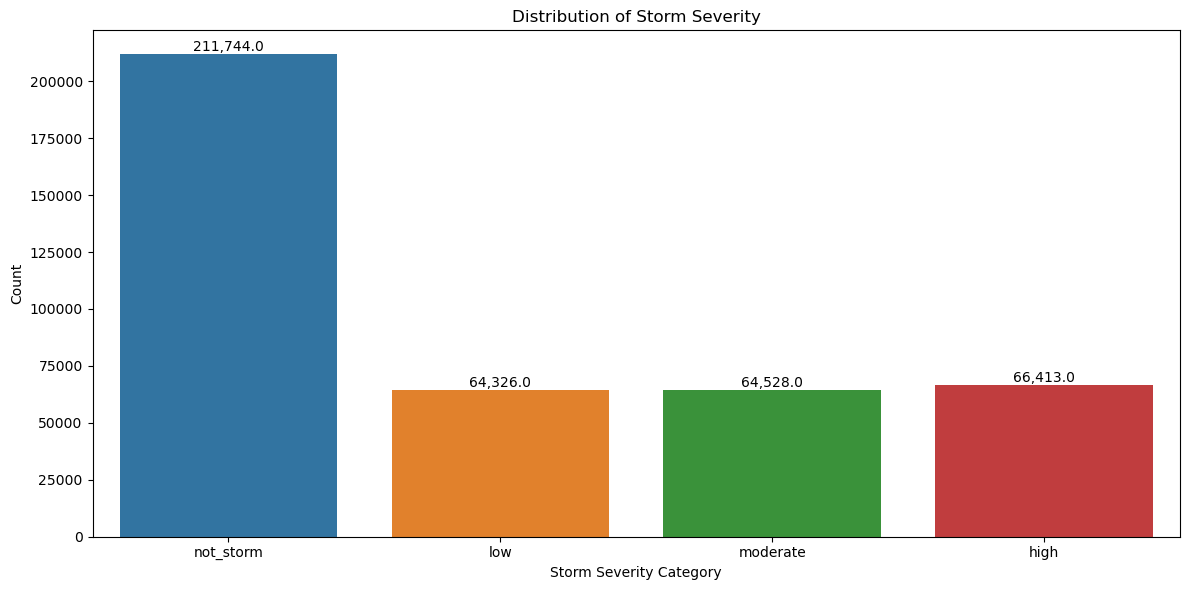

In [ ]:
# Visualize the storm severity distribution
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='storm_severity', data=df, order=['not_storm', 'low', 'moderate', 'high'])
plt.title('Distribution of Storm Severity')
plt.xlabel('Storm Severity Category')
plt.ylabel('Count')

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

#We see here that the storm severity is very balanced, .